# GSM of C. necator: model validation

### load in modules

In [1]:
import pandas as pd
import cobra
from cobra.flux_analysis import pfba
import json
import matplotlib.pyplot as plt
from cobra import Model, Reaction, Metabolite
import numpy as np
from cobra.flux_analysis.variability import flux_variability_analysis


In [2]:
m = cobra.io.read_sbml_model('../Model/iCN1361.xml')


Academic license - for non-commercial use only - expires 2021-12-27
Using license file /Users/mbznp/gurobi.lic


## Carbon source utilisation

#### load in in vivo phenotypes

In [3]:
carbon_sources = pd.read_excel('Data/Carbon_source_utilisation_phenotypes.xlsx', sheet_name='Sheet1')

#### Match the substrate names to the IDs used in the model 

In [6]:

substrates = list(carbon_sources['Metabolite ID'])
substrates2 = []
match = {}
match2 = {}
for i in substrates:
    if i[0:3] != 'M_':
        substrates2.append('M_'+i)
        match['M_' + i] = i
        match2[i] = 'M_' + i
    else:
        substrates2.append(i)
        match[i] = i
        match2[i] = i

### Simulate growth on each substrate in the model

In [7]:

# set the constraints
m.reactions.EX_BETA_D_FRUCTOSE_e.bounds = (0.0, 0.0)
m.reactions.EX_CARBON_DIOXIDE_e.bounds = (0.0, 1000.0)
m.reactions.R_ATPM.bounds = (3.0, 1000.0)
m.objective = 'R_Biomass'
m.objective_direction = 'max'
m.reactions.R_Biomass.bounds = (0.0, 1000.0)

media = ['EX_OXYGEN_MOLECULE_e', 'EX_AMMONIUM_e', 'EX_SULFATE_e', 'EX_FE2_e', 'EX_Pi_e', 'EX_PROTON_e', 'EX_WATER_e']


for i in m.reactions:
    if i.id not in media:
        if 'EX_' in i.id:
            if '_e' in i.id:
                i.bounds = (0.0, 1000.0)
            else:
                i.bounds = (0.0, 0.0)
    else:
        i.bounds = (-1000.0, 1000.0)


growth_phenotypes = {}
# check to see if metabolite in the model
for met in substrates2:
    #print(met)
    
    # check if in the model
    if met in m.metabolites:
        
        with m:
            # add transport reaction if not already in the model
            tx_name1 = 'EX_' + met 
            tx_name2 = 'EX_' + met.split('M_')[1] + '_e'
            if tx_name1 not in m.reactions and tx_name2 not in m.reactions:
                reaction = Reaction(met + '_tx')
                reaction.name = met + ' transporter'
                reaction.lower_bound = -10.0
                reaction.upper_bound = 0.0
                reaction.add_metabolites({m.metabolites.get_by_id(met) : -1.0})
                m.add_reaction(reaction)
            elif tx_name1 in m.reactions:
                m.reactions.get_by_id(tx_name1).bounds = (-10.0, 0.0)
            elif tx_name2 in m.reactions:
                m.reactions.get_by_id(tx_name2).bounds = (-10.0, 0.0)
                

                
                
            # check whether solution exists
            try:
                
                sol = pfba(m)
                #print(reaction.id, sol[reaction.id], sol['R_Biomass'])
                if sol['R_Biomass'] > 0.01:
                    growth_phenotypes[met] = 1.0
                else:
                    growth_phenotypes[met] = 0.0
            except:
                growth_phenotypes[met] = 0.0
    else:
        growth_phenotypes[met] = 0.0
        
        
        





In [8]:
### Print results to dataframe
df = pd.DataFrame(index = substrates2)

GSM_phenotypes = []
Experimental_phenotypes = []
substrate = []
metabolite_ID = []
result = []

FP = 0
FN = 0
TP = 0
TN = 0
false_positives = []
false_negatives = []

for i, j in growth_phenotypes.items():
    if j == 1.0:
        for ind, met in enumerate(carbon_sources['Metabolite ID']):
            if met == match[i]:
                if carbon_sources['Experimental'][ind] == 'X':
                    result.append('FP')
                    GSM_phenotypes.append('O')
                    Experimental_phenotypes.append('X')
                    metabolite_ID.append(met)
                    substrate.append(carbon_sources['Substrate'][ind])
                    FP += 1
                    #false_positives.append(i)
                    
                elif carbon_sources['Experimental'][ind] == 'O':
                    result.append('TP')
                    GSM_phenotypes.append('O')
                    Experimental_phenotypes.append('O')
                    metabolite_ID.append(met)
                    substrate.append(carbon_sources['Substrate'][ind])
                    TP += 1
                    
                    
    if j == 0.0:
        for ind, met in enumerate(carbon_sources['Metabolite ID']):
            if met == match[i]:
                if carbon_sources['Experimental'][ind] == 'X':
                    result.append('TN')
                    GSM_phenotypes.append('X')
                    Experimental_phenotypes.append('X')
                    metabolite_ID.append(met)
                    substrate.append(carbon_sources['Substrate'][ind])
                    TN += 1
                    
                    
                elif carbon_sources['Experimental'][ind] == 'O':
                    result.append('FN')
                    GSM_phenotypes.append('X')
                    Experimental_phenotypes.append('O')
                    metabolite_ID.append(met)
                    substrate.append(carbon_sources['Substrate'][ind])
                    FN += 1
                    false_negatives.append(i)

df.insert(0, column = 'Substrate', value = substrate)
df.insert(1, column = 'Metabolite ID', value = metabolite_ID)
df.insert(2, column = 'GSM phenotype', value = GSM_phenotypes)
df.insert(3, column = 'Experimental phenotype', value = Experimental_phenotypes)
df.insert(4, column = 'Result', value = result)

print('Number of tested carbon sources: ', len(substrates2))
print('Number of true positives: ', TP)
print('Number of false positives: ', FP)
print('Number of true negatives: ', TN)
print('Number of false negatives: ', FN)
overall_accuracy = (TP+TN)/(TP+TN+FP+FN)
print('Overall accuracy: ',  overall_accuracy)

Number of tested carbon sources:  131
Number of true positives:  62
Number of false positives:  14
Number of true negatives:  53
Number of false negatives:  2
Overall accuracy:  0.8778625954198473


### Save to excel file

In [154]:
df.to_excel('SupplementaryFile2_CarbonSourceUtilisation.xlsx')

## Validation of fluxes for frowth on fructose

### Prediction of external fluxes

In [9]:


# turn all uptake transports off if not in media
media = ['EX_OXYGEN_MOLECULE_e', 'EX_AMMONIUM_e', 'EX_SULFATE_e', 'EX_FE2_e', 'EX_Pi_e']

for i in m.reactions:
    if i.id not in media:
        if 'EX_' in i.id:
            if '_e' in i.id:
                i.bounds = (0.0, 1000.0)
            else:
                i.bounds = (0.0, 0.0)
    else:
        i.bounds = (-1000.0, 1000.0)
            
m.reactions.EX_BETA_D_FRUCTOSE_e.bounds = (-2.6, -2.6)
m.reactions.R_FRUPTS.bounds = (0.0, 0.0) # previous study found the ABC is the active reaction [ref]
m.objective = 'R_Biomass'
sol_fru = pfba(m)

print('Growth rate: ', sol_fru['R_Biomass'])
for i in m.reactions:
    if 'EX_' in i.id:
        if abs(sol_fru[i.id]) > 0.0:
            print(i.id, sol_fru[i.id])

Growth rate:  0.2508488569335877
EX_OXYGEN_MOLECULE_e -4.905131162654806
EX_AMMONIUM_e -2.6300828298148615
EX_WATER_e 11.943170535310363
EX_PROTON_e 2.310984468351571
EX_CARBON_DIOXIDE_e 5.205802633660161
EX_SULFATE_e -0.0405706350060987
EX_Pi_e -0.22004504220275023
EX_BETA_D_FRUCTOSE_e -2.6
EX_FE2_e -0.0012246885197974523
EX_CH33ADO_e 0.00178206113406561


|  Substrate           | In vivo flux  | In silico flux |
|------------------|---------------|---------------|
| Fructose     | -2.6 |   -2.6* |
| Oxygen  | -4.6+/-0.3 |  -4.91 |
| Sulfate    | - |   -0.04 |
| Carbon dioxide  | - |  5.21 |
| Ammonium | - |    -2.63 |  
| Phosphate | - |   -0.22 |
| Growth rate | 0.25+/-0.08 |  0.25 |


### Prediction of internal fluxes using 13-C MFA analysis

#### load 13-C data

In [10]:

c13_model = pd.read_excel('Data/C13_MFA_results.xlsx', sheet_name='Sheet1')
reac_mappings = pd.read_excel('Data/ReactionName_mappings.xlsx', sheet_name='Sheet1')


R correlation coefficient:  0.9388814469841198 p-value:  6.624009342962001e-16
R-Squared correlation coefficient:  0.8814983714909945


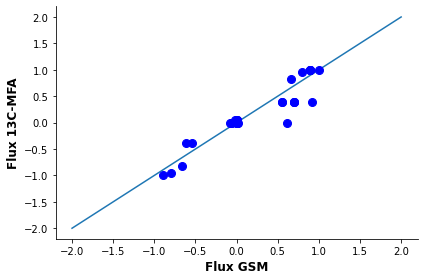

In [11]:


# Exclude the anaplerosis reactions
reactions_exclude = ['R_OXALODECARB_RXN', 'R_PEPSYNTH_RXN', 'R_PEPDEPHOS_RXN', 'R_PEPCARBOX_RXN', 'R_PEPCARBOX_RXN2', 'R_MALIC_NADP_RXN']

# Compare the results and add to list for correlation
gsm_vals = []
c13_vals = []
c13_vals2 = {}
gsm_vals2 = {}
for ind, r in enumerate(c13_model['Reaction ID']):
    reacs = r.split(';')
    if reacs[0] not in reactions_exclude:
        if len(reacs) > 1.0:
            sum_flux = 0.0
            for reaci in reacs:
                sum_flux += sol_fru[reaci]/2.6 # normalise the flux to 1 mmol/gDCW/h of fructose

            c13_vals.append(float(c13_model['13C-MFA'][ind]))
            c13_vals2[reaci] = c13_model['13C-MFA'][ind]
            gsm_vals.append(float(sum_flux))
            gsm_vals2[reaci] = float(sum_flux)
           
        else:
            c13_vals.append(float(c13_model['13C-MFA'][ind]))
            gsm_vals.append(float(sol_fru[reacs[0]]/2.6))
            c13_vals2[reacs[0]] = c13_model['13C-MFA'][ind]
            gsm_vals2[reacs[0]] = sol_fru[reacs[0]]/2.6
                 
        
        
from scipy import stats

x = np.linspace(-2, 2,2)
y = x
plt.plot(x, y)

plt.plot(gsm_vals, c13_vals, 'bo', markersize = 8)
axes = plt.gca()

plt.rc('axes', linewidth = 2.0)
plt.xticks(fontsize=10, weight = 'normal')
plt.yticks(fontsize=10, weight = 'normal')

axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.xlabel('Flux GSM', fontsize = 12, weight = "bold")
plt.ylabel('Flux 13C-MFA', fontsize = 12, weight = "bold")
plt.savefig('C13_Correlation.png', format = 'png')
plt.tight_layout()
slope, intercept, r_value_bio_out, p_value, std_err = stats.linregress(gsm_vals, c13_vals)
print('R correlation coefficient: ', r_value_bio_out, 'p-value: ', p_value)
print('R-Squared correlation coefficient: ', r_value_bio_out**2)

#### Flux variability analysis to whether the 13C flux values lie within the ranges at 90% of the optimal

In [12]:
C13reacs = [] # only run FVA on the reactions in central carbon metabolism to save time
for ind, r in enumerate(c13_vals2.keys()):
    reacs = r.split(';')
    for reac in reacs:
        C13reacs.append(reac)

In [13]:
res90 = flux_variability_analysis(m, fraction_of_optimum = 0.9, reaction_list=C13reacs, processes = 6, pfba_factor= 1.2)


In [14]:
count = 0.0
for ind, i in enumerate(res90['minimum']):
    if res90['minimum'].index[ind] in c13_vals2:
        if res90['minimum'][ind]/2.6 <= c13_vals2[res90['minimum'].index[ind]] <= res90['maximum'][ind]/2.6:
            count += 1.0
        else:
            print(res90['minimum'].index[ind], i/2.6, res90['maximum'][ind]/2.6, c13_vals2[res90['minimum'].index[ind]]) 
            
print('Number of reactions that agree with the FVA ranges: ', count)

R_2TRANSKETO_RXN -0.3721974472259234 -0.05036045015102773 -0.008
R_RIBULP3EPIM_RXN -0.7103892597581822 -0.06671526560840808 -0.008
R_PHOSGLYPHOS_RXN -0.8152530731293368 0.9911100233109745 -0.95
R_GAPOXNPHOSPHN_RXN -0.99111002331092 0.8152530731293384 0.95
R_CITSYN_RXN 0.49449980799642834 1.5102021957535061 0.393
R_ACONITATEDEHYDR_RXN 0.49449980799641646 1.2755561258145174 0.393
R_ISOCIT_CLEAV_RXN 2.9386393651895538e-05 1.149489385359666 0.0
R_FUMHYDR_RXN -1.2238990237317333 -0.40194384472740835 -0.393
Number of reactions that agree with the FVA ranges:  25.0


#### Save to excel file

In [161]:
df = pd.DataFrame(index = gsm_vals2.keys())


gsm_flux = []
c13_flux = []
reacs_stoich = []
FVA_min = []
FVA_max = []
for ind, i in enumerate(gsm_vals2.keys()):
    gsm_flux.append(gsm_vals2[i])
    c13_flux.append(c13_vals2[i])
    FVA_min.append(res90['minimum'][i])
    FVA_max.append(res90['maximum'][i])
    reacs_stoich.append(m.reactions.get_by_id(i).reaction)
    
df.insert(0, column = 'Reaction', value = reacs_stoich)   
df.insert(1, column = '13C-MFA flux', value = c13_flux)
df.insert(2, column = 'GSM flux (pFBA)', value = gsm_flux)
df.insert(3, column = 'FVA (min.)', value = FVA_min)
df.insert(4, column = 'FVA (max.)', value = FVA_max)

In [162]:
df.to_excel('SupplementaryFile3_13CMFA.xlsx')

#### Plot the barcharts comparing 13-C and GSM flux values (Figure 1b)

In [163]:
reac_index = {}
reac_titles = {}
for ind, r in enumerate(reac_mappings['Reaction']):
    reac_index[r] = reac_mappings['Index'][ind]
    reac_titles[r] = reac_mappings['Abbreviation'][ind]

In [164]:
# plot the fluxes of each condition on the plot

x = np.arange(2)  # the label locations
rev = [34, 36, 18, 15, 20, 10, 2, 21]
# folder to save files to
folder_name = '../../barcharts_13c/'
cit = 0
for indr, r in enumerate(reac_mappings['Reaction']): 
    if r in c13_vals2.keys():
        if reac_mappings['Index'][indr] in rev:

            y = [abs(c13_vals2[r]), abs(gsm_vals2[r])]
        elif reac_mappings['Index'][indr] == 13:
            y = [-(c13_vals2[r]), abs(gsm_vals2[r])]
        else:
            if abs((c13_vals2[r])) < 0.001 and abs((gsm_vals2[r])) < 0.001:
                y = [0.0, 0.0]
            elif abs((c13_vals2[r])) >= 0.001 and abs((gsm_vals2[r])) < 0.001:
                y = [(c13_vals2[r]), 0.0]
            elif abs((c13_vals2[r])) < 0.001 and abs((gsm_vals2[r])) >= 0.001:
                y = [0.0, gsm_vals2[r]]
            else:
                y = [c13_vals2[r], gsm_vals2[r]]

        ax = plt.figure()
        plt.rc('axes', linewidth = 6.0)
        barlist = plt.bar(x, y, align='center', alpha=0.8, ecolor='black', capsize=10,error_kw=dict(lw=7, capsize=10, capthick=7),  linewidth = 4)
        barlist[0].set_color('darkred')
        barlist[0].set_edgecolor('k')
        barlist[0].set_linewidth(10)
        barlist[1].set_color('darkblue')
        barlist[1].set_edgecolor('k')
        barlist[1].set_linewidth(10)



        font = {'family' : 'bold',
                'weight' : 'bold',
                'size'   : 85}

        plt.rc('font', **font)

        plt.xticks([])
        barlist[0].axes.spines['right'].set_visible(False)
        barlist[0].axes.spines['top'].set_visible(False)
        barlist[0].axes.spines['bottom'].set_visible(False)
        barlist[0].axes.spines['left'].set_color('black')
        barlist[0].axes.spines['left'].set_linewidth(10)


        x1 = np.array([0, 1])
        y = np.array([0, 0])
        plt.plot(x1, y, 'k', linewidth = 10)
        plt.xlabel(reac_mappings['Abbreviation'][indr], fontweight = 'bold')
        plt.title(reac_mappings['Index'][indr])


        plt.rc('font', **font)
        plt.savefig(folder_name+str(reac_mappings['Index'][indr]) + '_' + str(reac_mappings['Abbreviation'][indr]) + '.png',  bbox_inches = 'tight')






#### Plot the FVA flux ranges (Figure 1c)

In [165]:
import numpy as np
import matplotlib.pyplot as plt

objects = c13_vals2.keys() 
y_pos = np.arange(len(objects))
x = np.array(range(len(objects)))
min_val = []
max_val = []
span = []
for ind, i in enumerate(c13_vals2.keys()):
    min_val.append(res90['minimum'][ind]/2.6)
    max_val.append(res90['maximum'][ind]/2.6)
    span.append(res90['maximum'][ind]/2.6 - res90['minimum'][ind]/2.6)
    
    
    
fig, ax = plt.subplots(figsize=(9,10))   
#ax.barh(width=width, left=start, height=0.3, y=yval)
#ax.barh(bottom=yval, width=width, left=start, height=0.3)
ax.barh(width = span, left=min_val, height=0.8, y = y_pos, alpha=0.5)
plt.scatter(c13_vals, y_pos, c = 'darkred')
plt.scatter(gsm_vals, y_pos, c = 'darkblue')

reac_Ids = []
for i in C13reacs:
    reac_Ids.append(reac_titles[i])
plt.yticks(y_pos, reac_Ids)
#plt.ylim(0)
plt.ylabel('Reaction', fontsize = 16, weight = "bold")
plt.xlabel('Flux (mmol/gDCW/h)', fontsize = 16, weight = "bold")
plt.rc('axes', linewidth = 1.5)
plt.xticks(fontsize=16, weight = 'normal')

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.yticks(fontsize=14, weight = 'normal')
plt.tight_layout()
plt.setp(ax.spines.values(), linewidth=1.5)
plt.savefig('Figure1c.svg', format= 'svg', bbox_inches='tight')


### Calculation of P/O ratio

In [15]:
print('P/O ratio (ATP production / Oxygen atoms) :', sol_fru['R_ATPSynth']/abs(sol_fru['EX_OXYGEN_MOLECULE_e']*2.0))


P/O ratio (ATP production / Oxygen atoms) : 1.6320667165631115


## Single gene deletion phenotypes - comparison to SBRC TraDIS gene essentiality study

In [16]:
# load in the genes and in vivo phenotypes...
IPKM_fmm = pd.read_excel('Data/TraDIS_results.xlsx', sheet_name = 'IPKM_FMM')
IPKM_sob = pd.read_excel('Data/TraDIS_results.xlsx', sheet_name = 'IPKM_SOB')
low_coverage = pd.read_excel('Data/TraDIS_results.xlsx', sheet_name = 'low_coverage')


In [17]:
# take the logarithm + 1 of the IPKM values for both SOB and FMM media conditions
log2_IPKM = {}
for ind, gene in enumerate(IPKM_fmm['Unnamed: 0']):
    log2_IPKM[gene] = np.log2(IPKM_fmm['IPKM_curated'][ind] + 1)
    
log2_IPKM_sob = {}
for ind, gene in enumerate(IPKM_sob['Unnamed: 0']):
    log2_IPKM_sob[gene] = np.log2(IPKM_sob['IPKM_curated'][ind] + 1)

### Simulate single gene deletions in the GSM

In [18]:
# Add column to excel file with GSM result
m.reactions.R_Biomass.bounds = (0.0, 1000.0)

# minimal media
essential = []
non_essential = []
growth_limiting = []
oxygen = []
sol_wt = pfba(m)
growth_wt = sol_wt['R_Biomass']
oxygen_wt = sol_wt['EX_OXYGEN_MOLECULE_e']
for ind, i in enumerate(m.genes):
    #print(ind, i.id)
    with m:
        m.genes.get_by_id(i.id).knock_out()
        try:
            sol_ko = m.optimize()
            if sol_ko.status != 'infeasible':
                if sol_ko['R_Biomass'] > 0.05:
                    #print(sol_ko['R_Biomass'])
                    non_essential.append(i.id)
                    if sol_ko['R_Biomass'] < growth_wt*0.85:
                        growth_limiting.append(i.id)
                    if sol_ko['EX_OXYGEN_MOLECULE_e'] < oxygen_wt*1.01:
                        oxygen.append(i.id)
                        #print(i.id, sol_ko['EX_OXYGEN_MOLECULE_e'])
                else:
                    essential.append(i.id)
            
            else:
                essential.append(i.id)

        except:
            essential.append(i.id)
            
            
            
           

/opt/anaconda2/envs/pyTFA_2/lib/python3.7/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


### Simulate reaction deletions to check if the reaction is essential

In [19]:

# minimal media
essential_reacs = []
non_essential_reacs = []
growth_limiting_reacs = {}

#m.reactions.EX_OXYGEN_MOLECULE_e.bounds = (-3.0, 1000.0)

for i in m.reactions:
    #print(ind, i.id)

    with m:
        m.reactions.get_by_id(i.id).bounds = (0.0, 0.0)
        try:
            sol_ko = m.optimize()
            if sol_ko.status != 'infeasible':
                if sol_ko['R_Biomass'] > 0.05:
                    non_essential_reacs.append(i.id)
                else:
                    essential_reacs.append(i.id)
            else:
                essential_reacs.append(i.id)
        except:
            essential_reacs.append(i.id)




In [172]:
# save essential reactions to be loaded for determining the lower cutoff in 'GSM_nitrogenlimitation.ipynb'
with open('Cnec_essential_reactions.json', 'w') as fn:
    json.dump(essential_reacs, fn)

In [21]:
### Get the false positives, false negatives
# How many genes are non-essential but low IPKM
false_negatives2 = []
false_positives2 = []
true_negatives2 = []
true_positives2 = []

# low coverage genes
low_coverage_genes = []
for ind, i in enumerate(low_coverage['Low coverage']):
    low_coverage_genes.append(i)

for gene in non_essential:
    if gene not in low_coverage_genes:
        if gene in log2_IPKM:
            if log2_IPKM[gene] < 4.24:        
                #print(gene)
                false_negatives2.append(gene)
            elif log2_IPKM[gene] > 4.24:
                true_negatives2.append(gene)



for gene in essential:
    if gene != 'Spontaneous':
        if gene not in low_coverage_genes:
            if gene in log2_IPKM:
                if log2_IPKM[gene] > 4.24 and log2_IPKM_sob[gene] > 4.24:        
                    #print(gene)
                    false_positives2.append(gene)
                elif log2_IPKM[gene] < 4.24 or log2_IPKM_sob[gene] < 4.24:
                    true_positives2.append(gene)

len(set(false_negatives2))


# how many of the 141 are from essential reactions? so isoenzyme issue
FN_reac_ess = []
other = []
count = 0
for gene in false_negatives2:
    check = 0
    for r in m.genes.get_by_id(gene).reactions:
        if r.id in essential_reacs:
            FN_reac_ess.append(gene)
            count += 1
            check = 1
    if check == 0:
        other.append(gene)
            
print(count)
print(len(set(other)))
print(len(set(FN_reac_ess)))
            

120
46
31


In [22]:
print('True positives (essential in TraDIS and GSM): ', len(true_positives2))
print('True negatives (non-essential in TraDIS and GSM): ', len(true_negatives2))
print('False positives (non-essential in TraDIS and essential in GSM): ', len(false_positives2))
print('False negatives (essential in TraDIS and non-essential in GSM): ', len(false_negatives2))

True positives (essential in TraDIS and GSM):  131
True negatives (non-essential in TraDIS and GSM):  991
False positives (non-essential in TraDIS and essential in GSM):  28
False negatives (essential in TraDIS and non-essential in GSM):  77


In [23]:
print('Overall accuracy: ', (len(true_positives2) + len(true_negatives2))/(len(true_positives2) + len(true_negatives2) + len(false_negatives2) + len(false_positives2)))
print('Precision: ', len(true_positives2)/(len(true_positives2)+ len(false_positives2)))
print('Recall: ', len(true_positives2)/(len(true_positives2) + len(false_negatives2)))

Overall accuracy:  0.9144254278728606
Precision:  0.8238993710691824
Recall:  0.6298076923076923


In [24]:
print('number of FN genes that are associated to an essential reactions: ',  len(set(FN_reac_ess)))

number of FN genes that are associated to an essential reactions:  31


### Save results to excel

In [181]:
# to excel file
genes = []
for i in m.genes:
    if i.id != 'Spontaneous':
        genes.append(i.id)
        
df = pd.DataFrame(index = genes)

GSM_essentiality = []
log2_fmm = []
log2_sob = []
tradis_essentiality = []
low_coverage = []

for i in genes:
    if i in essential:
        GSM_essentiality.append(0)
    elif i in non_essential:
        GSM_essentiality.append(1)
    
    if i in log2_IPKM.keys():
        log2_fmm.append(log2_IPKM[i])
        log2_sob.append(log2_IPKM_sob[i])
        if log2_IPKM[i] < 4.24 or log2_IPKM_sob[i] < 4.24:
            tradis_essentiality.append(0)
        else:
            tradis_essentiality.append(1)
    else:
        log2_fmm.append('')
        log2_sob.append('')
        tradis_essentiality.append('')
        
    if i in low_coverage_genes:
        low_coverage.append(1)
    else:
        low_coverage.append(0)
        
df.insert(0, column= 'GSM prediction (0 - essential, 1 - non-essential)', value = GSM_essentiality)
df.insert(1, column= 'log2 (IPKM_FMM + 1)', value = log2_fmm)
df.insert(2, column = 'log2 (IPKM_SOB + 1)', value = log2_sob)
df.insert(3, column = 'Essential in TraDIS (cutoff = 4.24)', value = tradis_essentiality)
df.insert(4, column = 'Low coverage in TraDIS result?', value = low_coverage)

classification_group = []

for ind, i in enumerate(df['GSM prediction (0 - essential, 1 - non-essential)']):
    if df['Low coverage in TraDIS result?'][ind] == 0:
        if i == 0 and df['Essential in TraDIS (cutoff = 4.24)'][ind] == 0:
            classification_group.append('TP')
        elif i == 0 and df['Essential in TraDIS (cutoff = 4.24)'][ind] == 1:
            classification_group.append('FP')
        elif i == 1 and df['Essential in TraDIS (cutoff = 4.24)'][ind] == 0:
            classification_group.append('FN')
        elif i == 1 and df['Essential in TraDIS (cutoff = 4.24)'][ind] == 1:
            classification_group.append('TN')
        else:
            classification_group.append('')
    else:
        classification_group.append('')
        
        
    
        
df.insert(5, column = 'Classification', value = classification_group)


    
        

### Get Biocyc Pathways of the reactions in the FP and FN

In [182]:
reac_info = pd.read_excel('../SupplementaryFiles/SupplementaryFile1_GSMinfo.xlsx', sheet_name='Table S1')

In [183]:
biocyc_pathways = {}
for ind, i in enumerate(reac_info['SBML ID']):
    biocyc_pathways[i] = reac_info['BioCyc pathways'][ind]

In [184]:
FN_gene_pathways = {}
for i in false_negatives2:
    pathways = []
    for r in m.genes.get_by_id(i).reactions:
        if str(biocyc_pathways[r.id]) != 'nan':
            paths = biocyc_pathways[r.id].split(' // ')
            for p in paths:
                pathways.append(p)
    FN_gene_pathways[i] = list(set(pathways))
    
    

        
FP_gene_pathways = {}
for i in false_positives2:
    pathways = []
    for r in m.genes.get_by_id(i).reactions:
        if str(biocyc_pathways[r.id]) != 'nan':
            paths = biocyc_pathways[r.id].split(' // ')
            for p in paths:
                pathways.append(p)
    FP_gene_pathways[i] = list(set(pathways))

### Gene KO results in model with reduced growth rate by > 15% of wild type

In [23]:
growth_limiting

['H16_A1053',
 'H16_A1060',
 'H16_A1052',
 'H16_A1055',
 'H16_A1050',
 'H16_A1063',
 'H16_A1051',
 'H16_A1058',
 'H16_A1057',
 'H16_A1056',
 'H16_A2631',
 'H16_A2630',
 'H16_A2632',
 'H16_A2629']

### Gene KO results in model requiring increased oxygen uptake

In [24]:
for i in oxygen:
    if i not in growth_limiting and i in false_negatives2:
        print(i)

H16_A2325
H16_A2324
H16_A1188


### Check whether isoenzymes are on in expression data

#### Function for calculating reaction expression

In [12]:
### reactions to block

def map_exp_to_reacs(m, gene_express, condition = 'f16', unconstrained_reacs = []):
    
    reac_expression = {}
    reacs_low_expression = []
    for r in m.reactions:
        if r.id not in unconstrained_reacs:

            # get a list of 'or' genes that includes 'and' genes in internal list
            genes = r.gene_reaction_rule.split('or')
            genes_or = []
            for g in genes:
                gene = g.replace(' ', '').replace('(', '').replace(')', '')
                genes_or.append(gene.split('and'))


            # loop through genes - get the sum of expression of the 'or' genes
            exp_max = 0.0
            for g in genes_or:

                # get minimum
                min_gene_and = 0.0
                if g[0] in list(gene_express['gene']):
                    for ind, gene_tag in enumerate(gene_express['gene']):
                        if gene_tag == g[0]:
                            min_gene_and = gene_express[condition][ind] # if not in the list then leave as preset zero


                # if more than one gene in list ('and' relationship)  
                if len(g) > 1:
                    for gi in g[1:]: # loop through rest of genes in 'and' list and check if in the proteomics data
                        if gi in list(gene_express['gene']):
                            for ind, gene_tag in enumerate(gene_express['gene']):
                                if gene_tag == gi:
                                    if gene_express[condition][ind] < min_gene_and: # if less than value already set then re-value
                                        min_gene_and = gene_express[condition][ind]

                exp_max += min_gene_and # add to the 'or' expression 
                
                # store expression for each reaction
                reac_expression[r.id] = exp_max
        else:
            reac_expression[r.id] = -1
                

                
                
    
    return reac_expression
                


        
                    
        
    
    

    

In [13]:
gene_express = pd.read_excel('Data/gene_exp_fructose.xlsx')
# exclude transport and spontaneous reactions
unconstrained_reacs = ['R_ATPM', 'R_Biomass']
for r in m.reactions:
    if 'EX_' in r.id:
        unconstrained_reacs.append(r.id)
    if r.gene_reaction_rule == 'Spontaneous':
        unconstrained_reacs.append(r.id)
    if r.gene_reaction_rule == '':
        unconstrained_reacs.append(r.id)
        
RPKM_f16 = map_exp_to_reacs(m, gene_express, condition = 'f16', unconstrained_reacs = unconstrained_reacs)
RPKM_f26 = map_exp_to_reacs(m, gene_express, condition = 'f26', unconstrained_reacs = unconstrained_reacs)








0.2

In [34]:
FN_isoenzymes_exp_ratios = {}
count = 0
# Turn off the genes that are not expressed in the isoenzymes
genes_isoenzymes = list(set(FN_reac_ess)) # all FN genes associated to essential reactions
ess_genes = []
ess_genes_dic = {}
for i in genes_isoenzymes:
    for ind, gene in enumerate(gene_express['gene']):
        if i == gene:
            ess_gene_exp = gene_express['f16'][ind]

            
    
    # get the 'or' relationships
    isoenzymes_expressions = {}
    for r in m.genes.get_by_id(i).reactions:
        if r.id in essential_reacs: # find the essential reac its associated to
            if 'and' not in r.gene_reaction_rule:
                isoenzyme_express_reac = []
                isoenzyme_exp_dic = {}
                for g in r.genes:
                    if g.id != i:
                        match = 0 # check if the other genes associtaed to reaction are in the expression data (if not assign very small expression value)
                        for ind, gene in enumerate(gene_express['gene']):
                            if g.id == gene:
                                isoenzyme_express_reac.append(gene_express['f16'][ind]/ess_gene_exp) # divide the expression of other gene by the expression of FN gene under consideration
                                isoenzyme_exp_dic[g.id] = gene_express['f16'][ind]
                                match = 1
                        if match == 0:
                            isoenzyme_exp_dic[g.id] = 0.000000001
                            isoenzyme_express_reac.append(0.000000001)
                                
                                
                if all(x <= 0.2 for x in isoenzyme_express_reac): # if all the genes
                    FN_isoenzymes_exp_ratios[i] = isoenzyme_exp_dic
                    ess_genes.append(i)
                    ess_genes_dic[i] = ess_gene_exp
                    
            else:
                isoenzyme_express_reac = []
                isoenzyme_exp_dic = {}
                or_genes = r.gene_reaction_rule.split(' or ')
                #print(or_genes)
                for ors in or_genes:
                    if i in ors:
                        genes_and = ors.split(' and ')

                        exp = []
                        for gi in genes_and:
                            gi = gi.replace('( ', '')
                            gi = gi.replace(' )', '')
                            gi = gi.replace('(', '')
                            gi = gi.replace(')', '')
                            match = 0
                            for ind, gene in enumerate(gene_express['gene']):
                                if gi == gene:
                                    exp.append(gene_express['f16'][ind])
                                    isoenzyme_exp_dic[gi] = gene_express['f16'][ind]

                                    match = 1
                            if match == 0:
                                exp.append(0.000000001)
                                isoenzyme_exp_dic[g.id] = 0.000000001

                        i_min_exp = np.min(exp)
                        #print(i_min_exp)


                for ors in or_genes: 

                    if i not in ors:
                        genes_and = ors.split(' and ')
                            #print(genes_and)
                        exp = []
                        for gi in genes_and:
                            gi = gi.replace('( ', '')
                            gi = gi.replace(' )', '')
                            gi = gi.replace('(', '')
                            gi = gi.replace(')', '')
                            match = 0
                            for ind, gene in enumerate(gene_express['gene']):
                                if gi == gene:
                                    exp.append(gene_express['f16'][ind])
                                    isoenzyme_exp_dic[gi] = gene_express['f16'][ind]
                                    match = 1
                            if match == 0:
                                exp.append(0.000000001)
                                isoenzyme_exp_dic[g.id] = 0.000000001


                        isoenzyme_express_reac.append(np.min(exp)/i_min_exp)

                        min_exp = np.min(exp)
                        #print(isoenzyme_express_reac)




                if all(x <= 0.2 for x in isoenzyme_express_reac):
                    ess_genes.append(i)
                    ess_genes_dic[i] = ess_gene_exp
                    FN_isoenzymes_exp_ratios[i] = isoenzyme_exp_dic
        
                        

   
                        
len(set(ess_genes))       

17

### Calculate the updated accuracy measures with the isoenzymes blocked in the model if their expression is significantly less than the FN gene

In [28]:
tp_updated = true_positives2 + list(set(ess_genes))
fn_updated = []
for i in false_negatives2:
    if i not in ess_genes:
        fn_updated.append(i)
fp = false_positives2
tn = true_negatives2

In [29]:
print('Overall accuracy: ', (len(tp_updated) + len(tn))/(len(tp_updated) + len(tn) + len(fn_updated) + len(fp)))
print('Precision: ', len(tp_updated)/(len(tp_updated)+ len(fp)))
print('Recall: ', len(tp_updated)/(len(tp_updated) + len(fn_updated)))

Overall accuracy:  0.928280358598207
Precision:  0.8409090909090909
Recall:  0.7115384615384616


### Save FP information in the Excel file

In [192]:
df_FP_genes = pd.DataFrame(index = list(FP_gene_pathways.keys()))
pathways = []
for i, j in FP_gene_pathways.items():
    pathways.append(str(j))
df_FP_genes.insert(0, column = 'Metabolic pathways', value = pathways)




df_FN_genes = pd.DataFrame(index = list(FN_gene_pathways.keys()))
pathways = []
reason = []

for i, j in FN_gene_pathways.items():
    pathways.append(str(j))
    
    if i in growth_limiting:
        reason.append('Reduced growth rate of mutant by > 15% than wild type')        
    elif i in oxygen:
        reason.append('Increased oxygen requirement in mutant')        
    elif i in FN_reac_ess:
        if i in ess_genes:
            reason.append('Associated to essential reaction - highest expressed isoenzyme')
        else:
            reason.append('Associated to essential reaction')
    else:
        reason.append('')
        
    
        
        
        
df_FN_genes.insert(0, column = 'Metabolic pathways', value = pathways)
df_FN_genes.insert(1, column = 'Potential reason', value = reason)







#### write all dataframes to excel

In [193]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('SupplementaryFile4_GeneEssentiality.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df.to_excel(writer, sheet_name='GSM_essentiality_assessment')
df_FP_genes.to_excel(writer, sheet_name='False positives')
df_FN_genes.to_excel(writer, sheet_name='False negatives')


# Close the Pandas Excel writer and output the Excel file.
writer.save()